In [1]:
import numpy as np #biblioteka za rad sa MATRICAMA
import pandas as pd #biblioteka za rad sa DATAFRAME
import matplotlib.pyplot as plt #biblioteka za vizuelizaciju. PROSTIJA VIZUELIZACIJA
import seaborn as sns #biblioteka za vizuelizaciju. LEPSA VIZUELIZACIJA
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
%matplotlib inline

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF


import plotly.figure_factory as pfc

import scipy
from scipy import stats

from sklearn import preprocessing
#SHIFT + ENTER za izbacivanje OUTPUT-a

# 1. Preprocesiranje
Cilj preprocesiranja jeste da se dataset spremi za "učenje" tako što ćemo ga "očistiti" od podataka koji bi mogli da nam predstavljaju problem.

## 1.1. Dataset

In [2]:
train = pd.read_csv('train.csv') #učitavanje training set-a.
test = pd.read_csv('test.csv') #učitavanje test set-a.
testID = test['Id']

data = pd.concat([train.drop('SalePrice', axis=1), test], keys=['train', 'test']) #concat = spajanje.
#dropujemo "SalePrice" iz training set-a jer je to potrebno PREDVIVETI.
data.drop(['Id'], axis=1, inplace=True) #takodje dropujemo ID jer nam on trenutno nije neophodan.

In [3]:
data.head(2)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
train 0          60       RL         65.0     8450   Pave   NaN      Reg   
      1          20       RL         80.0     9600   Pave   NaN      Reg   

        LandContour Utilities LotConfig      ...       ScreenPorch PoolArea  \
train 0         Lvl    AllPub    Inside      ...                 0        0   
      1         Lvl    AllPub       FR2      ...                 0        0   

        PoolQC Fence MiscFeature MiscVal  MoSold  YrSold  SaleType  \
train 0    NaN   NaN         NaN       0       2    2008        WD   
      1    NaN   NaN         NaN       0       5    2007        WD   

         SaleCondition  
train 0         Normal  
      1         Normal  

[2 rows x 79 columns]

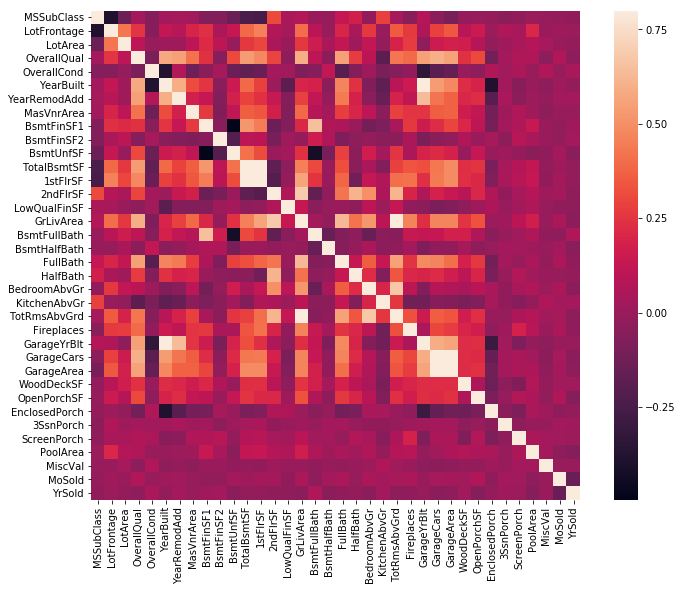

In [4]:
corrmat = train.drop(["Id", "SalePrice"], axis=1).corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [5]:
tempdf = pd.melt(corrmat.reset_index(), id_vars=['index'], value_vars=corrmat.index)

In [6]:
tempdf[(tempdf.value > 0.8) & (tempdf.value != 1)].drop_duplicates()

,index,variable,value
204,GarageYrBlt,YearBuilt,0.825667
408,1stFlrSF,TotalBsmtSF,0.819530
443,TotalBsmtSF,1stFlrSF,0.819530
562,TotRmsAbvGrd,GrLivArea,0.825489
807,GrLivArea,TotRmsAbvGrd,0.825489
869,YearBuilt,GarageYrBlt,0.825667
926,GarageArea,GarageCars,0.882475
961,GarageCars,GarageArea,0.882475


In [7]:
data = data.drop(['GarageYrBlt', '1stFlrSF', 'TotRmsAbvGrd', 'GarageCars'],  axis=1)

In [8]:
data.shape

(2919, 75)

#### Anomalije

Pre nego što nastavimo sa procesiranjem podataka, potrebno je da izvršimo validaciju, tj.da proverimo da li postoje podaci koji nisu realni, tj.koji nemaju smisla. Npr.atributi koji se odnose na godinu čija je vrednost veća od 2018. Takođe cene, razdaljine, površina ne smeju uzimati negativne vredosnti kao što i meseci moraju biti između
1 i 12.

In [9]:
years = ['YearBuilt', 'YearRemodAdd', 'YrSold'] #Svi atributi koji u sebi imaju podatak o GODINI
metrics = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
          '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
         'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'] #.... o VELIČINAMA

Provera da li postoji neka obzervacija kod koje je GODINA veća od 2018-e.

In [10]:
data[years].max() #maksimalne vredosti za svaki od atributa koji u sebi sadrže godinu.

YearBuilt       2010
YearRemodAdd    2010
YrSold          2010
dtype: int64

In [11]:
mask = (data[years] > 2018).any(axis=1)
data[mask] 

,,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


Postoji jedna obzervacija kod koje atribut(feature) "GarageYrBlt 2207.0" iskače iz normale.

In [12]:
data.loc[mask, 'GarageYrBlt'] = data[mask]['YearBuilt']

Provera da li postoje NEGATIVNE VREDNOSTI za veličinu parcela,garaže,trema itd.

In [13]:
mask = (data[metrics] < 0).any(axis=1) #provera da li postoji neka veličina koja iskače iz normale.
data[mask]

,,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,GarageYrBlt


Provera da li za sve obzervacije važi da MESECI uzimaju vrednosti od 1 do 12.

In [14]:
mask = ((data['MoSold'] > 12) | (data['MoSold'] < 1))
data[mask]

,,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,GarageYrBlt


#### Tipovi podataka
Kada je reč o tipovima podataka, postoje 4 velike grupe:
a.Kontinualni numerički atributi(dužine,površine,cene)
b.Diskretni numerički atributi - ne možemo da ih tretiramo kao numeričke atribute jer podržavaju poređenje i aritmetičke operacije(numerički rezultati,broj soba,godine)
c.Ordinalne kategoričke atribute - atribute koji daju kvalitativne/opisne rezultate("Dobar","Odličan") i koji podržavaju poređenja ali ne i aritmetičke operacije
d.Čisto kategoričke podatke

Odlučila sam da u potpunosti odvojim numeričke(i kontinualne i diskretne) od kategoričkih atributa pri čemu zadržavamo vezu između diskretnih numeričkih podataka i radićemo sa manje atributa.


In [15]:
#Numerički podaci
num_feats = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 
             'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 
             'BsmtQual', 'BsmtCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
             'HeatingQC', '2ndFlrSF', 'LowQualFinSF',
             'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
             'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
             'Fireplaces', 'FireplaceQu',
              'GarageArea', 'GarageQual', 'GarageCond',
             'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
             'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal',
             'YrSold']  

#Moramo da KONVERTUJEMO ono što je odgovoreno REČIMA("Odlično","Vrlo Dobro", "Dobro") za atribute u
#"grades" u NUMERIČKU skalu
grades = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
          'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
literal = ['Ex', 'Gd', 'TA', 'Fa', 'Po'] #Ex-Excelent, Gd-Good, Po-Poor
num = [9, 7, 5, 3, 2]

G = dict(zip(literal, num))

data[grades] = data[grades].replace(G)


#Kategorički podaci podrazumevaju sve ono što nisu numerički podaci
cat_feats = data.drop(num_feats, axis=1).columns 

In [16]:
#data[grades]

In [17]:
cat_feats

Index([u'MSSubClass', u'MSZoning', u'Street', u'Alley', u'LotShape',
       u'LandContour', u'Utilities', u'LotConfig', u'LandSlope',
       u'Neighborhood', u'Condition1', u'Condition2', u'BldgType',
       u'HouseStyle', u'RoofStyle', u'RoofMatl', u'Exterior1st',
       u'Exterior2nd', u'MasVnrType', u'Foundation', u'BsmtExposure',
       u'BsmtFinType1', u'BsmtFinType2', u'Heating', u'CentralAir',
       u'Electrical', u'Functional', u'GarageType', u'GarageFinish',
       u'PavedDrive', u'Fence', u'MiscFeature', u'MoSold', u'SaleType',
       u'SaleCondition', u'GarageYrBlt'],
      dtype='object')

## 1.2. Normalnost i spljoštenost

Većina regresionih modela mnogo efikasnije radi sa varijablama koje imaju normalnu(ili približno normalnu) raspodelu.
Napomena: U obzir nećemo uzimati diskretne numeričke atribute jer će, bez njihove analize, rezultati biti mnogo čiljiviji i pored toga, mnogi od diskretnih numeričkih atributa uzimaju samo nekoliko različitih vredosti tako da je normalnost veoma retka.

In [18]:
#log transformacija onoga što se želi predvideti.
price = np.log1p(train['SalePrice'])

In [19]:
#log transformacija spljoštenih kontinualnih numeričkih vrednosti
skewed_feats = data.loc['train'][metrics].apply(lambda x: x.skew(skipna=True)) #izračunavanje SPLJOŠTENOSTI(skewness)
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

data[skewed_feats] = np.log1p(data[skewed_feats])

In [20]:
skewed_feats

Index([u'LotFrontage', u'LotArea', u'MasVnrArea', u'BsmtFinSF1', u'BsmtFinSF2',
       u'BsmtUnfSF', u'TotalBsmtSF', u'2ndFlrSF', u'LowQualFinSF',
       u'GrLivArea', u'WoodDeckSF', u'OpenPorchSF', u'EnclosedPorch',
       u'3SsnPorch', u'ScreenPorch', u'PoolArea', u'MiscVal'],
      dtype='object')

## 1.3. Nedostajuće vredosti

U posmatranom dataset-u, postoje dva tipa nedostajućih vredosti. Prvi se odnosi na neke nedostajuće vredosti koje nisu zabaležene(mali broj njih) dok se drugi odnosi na nedostajući atribut za neku od obzervacija(kuća nema podrum ili garažu).

In [21]:
data.isnull().sum()[data.isnull().sum() > 0] #atributi koji imaju barem jednu nedostajuću vrednost

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageFinish     159
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
GarageYrBlt     2919
dtype: int64

##### MSZoning, Utilities, Exterior1st, Exterior2nd, Electrical, Functional and SaleType

In [22]:
feats = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'Electrical', 'Functional',
         'SaleType']
model = data.loc['train'].groupby('Neighborhood')[feats].apply(lambda x: x.mode().iloc[0]) 
#Grupišemo po "Neighborhood"i uzimamo MODE(Najčešća pojavljivanja) i nad time data.iloc[0] -first row of data frame

for f in feats:
    data[f].fillna(data['Neighborhood'].map(model[f]), inplace=True)
    #postavljamo najučestaliju vrednost umesto nedostajućih vredosnti

In [23]:
#model

##### Lot frontage

In [24]:
data["LotConfig"].value_counts()

Inside     2133
Corner      511
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64

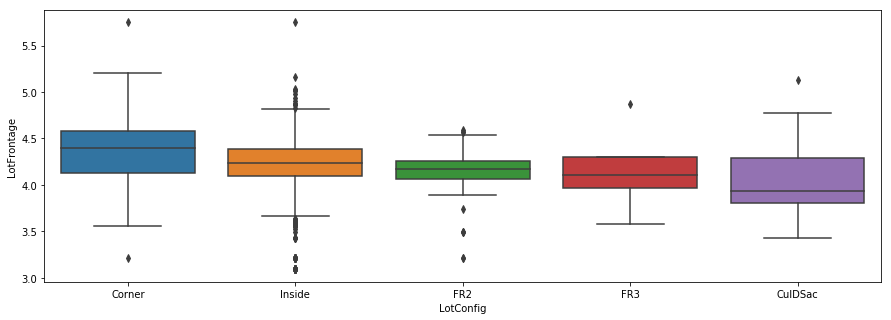

In [25]:
plt.subplots(figsize=(15,5))
boxdata = data.loc['train'].groupby('LotConfig')['LotFrontage'].median().sort_values(ascending=False)
order = boxdata.index

sns.boxplot(x='LotConfig', y='LotFrontage', order=order, data=data.loc['train'])

In [26]:
boxdata

LotConfig
Corner     4.394449
Inside     4.234107
FR2        4.174387
FR3        4.102609
CulDSac    3.931826
Name: LotFrontage, dtype: float64

In [27]:
data['LotFrontage'] = data['LotFrontage'].fillna(data.loc['train', 'LotFrontage'].median())
#nedostajuće vredosti popunjavamo sa MEDIJANOM(srednjom vrednošću).

##### KitchenQual

Jako je malo nedostajućih vrednosti kada je reč o atributu "KitchenQual" pa ćemo ga zameniti sa vrednosšću za atribut "OverallQual"

In [28]:
data['KitchenQual'].fillna(data['OverallQual'], inplace=True)

##### Podrumi, garaže, kamini i ostali atributi

Nedostajuće atribute(NA) ćemo nadomestiti tako što ćemo reći da kuća ne poseduje dotične atribute.

In [29]:
bsmt = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
        'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath',
        'BsmtHalfBath', 
        'TotalBsmtSF']
fire = ['Fireplaces', 'FireplaceQu']
garage = ['GarageQual', 'GarageCond', 'GarageType', 'GarageFinish', 
          'GarageArea']
masn = ['MasVnrType', 'MasVnrArea']
others = ['Alley', 'Fence', 'PoolQC', 'MiscFeature']

cats = data.columns[data.dtypes == 'object'] #Atributi ciji je datatype OBJECT
nums = list(set(data.columns) - set(cats))

#Kategorija "None" je takođe obrađena
data['MasVnrType'].replace({'None': np.nan}, inplace=True)

data[cats] = data[cats].fillna('0')
data[nums] = data[nums].fillna(0)


In [30]:
data.isnull().sum().sum()

0L

### Izmena tipova varijabli

Nakon analize, došla sam do zaključka da neki atributi nisu prezentovani odgovarajućim tipom:
"MSSubClass"-prikazan je kao INTEGER a predstavlja kategorički podatak tako da ćemo koristiti OBJECT.
"MoSold"-prikazan je kao INTEGER dok mesec predstavlja kategoričku promenljivu sa 12 mogućnosti tako da ćemo koristiti OBJECT.
"BsmtFullBath" i "BsmtHalfBath" predstavljeni su kao FLOAT a mi ćemo koristiti INTEGER.
"years" je predstavljen kao FLOAT a mi ćemo koristiti INTEGER.
"GarageCars"-prikazan je kao FLOAT a mi ćemo koristiti INTEGER.

In [31]:
data['MSSubClass'] = data['MSSubClass'].astype('object', copy=False) #int u object
data['MoSold'] = data['MoSold'].astype('object', copy=False) #int u object 
data['BsmtFullBath'] = data['BsmtFullBath'].astype('int64', copy=False) #float u int
data['BsmtHalfBath'] = data['BsmtHalfBath'].astype('int64', copy=False) #float u int
data[years] = data[years].astype('int64', copy=False) #float u int


### Grupisanje u posebnu kategoriju

Neke od kategorija kategoričkih atributa su jako loše reprezentovane te se iz njih ne može izvući nikakav zaključak. U cilju rešavanja ovog problema, sve problematične kategorije ćemo svrstati u jednu posebnu kategoriju.

In [32]:
categorical_data = pd.concat((data.loc['train'][cat_feats], price), axis=1)

In [33]:
low = 0.05 * data.loc['train'].shape[0] #barem 5% dataset-a treba da ima ovu vrednost

for feat in cat_feats:        
    #grupisaćemo kategorije na osnovu prosečne prodajne cene(average sale price)-mean()SalePrice
    #za svako pojavljivanje feat iz cat_feats, uzmi mi prosek za SalePrice i poredaj u opadajućem redosledu.
    order = ((categorical_data.groupby(feat).mean()).sort_values(by='SalePrice', 
                                                      ascending=False).index.values.tolist())
    
    #order - array(['Normal', 'Abnorml', 'Partial'], dtype=object)
    
    for i in range(0, len(order)): # i između 1 i 3
        N = (categorical_data[categorical_data[feat] == order[i]]
             .count().max()) # N=137
        j = i # j=2 i="Partial"
        while (N < low) & (N != 0): #Dok god postoji atribut čija je vrednost manja od 5% i različita je od 0
            j += 1 #...povećavaj mi kategoriju za 1

            if (j > len(order) - 1):
                # Ako smo stigli do kraja liste, vrati se na poslednju korisnu kategoriju
                # iz "order" liste
                j = i - 1
                break
            else: 
                N += (categorical_data[categorical_data[feat] == order[j]]
                      .count().max())
        if j < i:
            lim = len(order)
        else:
            lim = j

        for k in range(i, lim):
            categorical_data.replace({feat: {order[k]: order[j]}},
                                 inplace=True)
            data.replace({feat: {order[k]: order[j]}},
                                     inplace=True)            
    uniD = data[feat].unique()
    order = categorical_data[feat].unique()

    for i in uniD:
        if i not in order:
            ind = np.argsort(order - i)[0]
            data.replace({feat: {i: order[ind]}}, inplace=True)


In [34]:
data.columns

Index([u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea', u'Street',
       u'Alley', u'LotShape', u'LandContour', u'Utilities', u'LotConfig',
       u'LandSlope', u'Neighborhood', u'Condition1', u'Condition2',
       u'BldgType', u'HouseStyle', u'OverallQual', u'OverallCond',
       u'YearBuilt', u'YearRemodAdd', u'RoofStyle', u'RoofMatl',
       u'Exterior1st', u'Exterior2nd', u'MasVnrType', u'MasVnrArea',
       u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual', u'BsmtCond',
       u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1', u'BsmtFinType2',
       u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF', u'Heating', u'HeatingQC',
       u'CentralAir', u'Electrical', u'2ndFlrSF', u'LowQualFinSF',
       u'GrLivArea', u'BsmtFullBath', u'BsmtHalfBath', u'FullBath',
       u'HalfBath', u'BedroomAbvGr', u'KitchenAbvGr', u'KitchenQual',
       u'Functional', u'Fireplaces', u'FireplaceQu', u'GarageType',
       u'GarageFinish', u'GarageArea', u'GarageQual', u'GarageCond',
       u'Paved

## 1.4. Dummy encoding

Prvo moramo da prebacimo atribute sa 2 kategorije u 0-1 encoding. Automatsko korišćenje funkcije get_dummies bi ih konvertovala u dva odvojena atributa(feat_0 i feat_1)).

In [35]:
#Izmeštamo kolone sa samo jednom kategorijom
for feat in categorical_data.columns[:-1]: 
    uni = categorical_data.groupby(feat).mean().sort_values(by='SalePrice').index
    if (len(uni) < 2):
            data.drop(feat, axis=1, inplace=True) #Izmeštamo kolone sa samo jednom kategorijom
    elif len(uni) < 3: #kolona sa dve kategorije
        print("{}: {}".format(feat, uni))
        data[feat].replace({uni[0]: 0, uni[1]: 1}, inplace=True)
        data[feat] = data[feat].astype('int8')
    else:
        data[feat] = data[feat].astype('category')

MSZoning: Index([u'RM', u'RL'], dtype='object', name=u'MSZoning')
Alley: Index([u'Grvl', u'0'], dtype='object', name=u'Alley')
LotShape: Index([u'Reg', u'IR1'], dtype='object', name=u'LotShape')
LandContour: Index([u'Lvl', u'Low'], dtype='object', name=u'LandContour')
LandSlope: Index([u'Gtl', u'Mod'], dtype='object', name=u'LandSlope')
Condition1: Index([u'Feedr', u'Norm'], dtype='object', name=u'Condition1')
RoofStyle: Index([u'Gable', u'Hip'], dtype='object', name=u'RoofStyle')
BsmtFinType2: Index([u'Rec', u'Unf'], dtype='object', name=u'BsmtFinType2')
CentralAir: Index([u'N', u'Y'], dtype='object', name=u'CentralAir')
Electrical: Index([u'FuseA', u'SBrkr'], dtype='object', name=u'Electrical')
Functional: Index([u'Min2', u'Typ'], dtype='object', name=u'Functional')
PavedDrive: Index([u'N', u'Y'], dtype='object', name=u'PavedDrive')
Fence: Index([u'MnPrv', u'0'], dtype='object', name=u'Fence')
SaleType: Index([u'WD', u'New'], dtype='object', name=u'SaleType')


In [36]:
finaldata = pd.get_dummies(data)

Napomena: Varijable koje sadrže(prikazuju) da "kuća ne poseduje dotične atribute"(odnosi se na garažu, kamin, podrum), neće treitrati "0" kao normalnu kategoriju. Zato ćemo nulu da enkodiramo i za druge mogućnosti.

In [37]:
black_list = bsmt + fire + garage + masn + others
for feat in finaldata.columns:
    if ('_0' in feat) and (feat.split("_")[0] in black_list):
        finaldata.drop(feat, axis=1, inplace=True)

In [38]:
finaldata.shape #(broj obzervacija, broj atributa)

(2919, 127)

## 1.5. Shapiro-Wilk test

##### FinalData : Shapiro-Wilk test za Normalnu raspodelu

In [39]:
for column in finaldata.columns:
    test_result = scipy.stats.shapiro(
        finaldata.loc['train'][column]
    )
    print(column)
    print(test_result)
    if test_result[1] > 0.05:
        print("Usvajamo H0!\n")
    else:
        print("Ne usvajamo H0!\n")

MSZoning
(0.450009822845459, 0.0)
Ne usvajamo H0!

LotFrontage
(0.9044284820556641, 2.818352014763149e-29)
Ne usvajamo H0!

LotArea
(0.9054417014122009, 3.8094117909470694e-29)
Ne usvajamo H0!

Alley
(0.2576040029525757, 0.0)
Ne usvajamo H0!

LotShape
(0.6101342439651489, 0.0)
Ne usvajamo H0!

LandContour
(0.24859941005706787, 0.0)
Ne usvajamo H0!

LandSlope
(0.23361438512802124, 0.0)
Ne usvajamo H0!

Condition1
(0.3339800238609314, 0.0)
Ne usvajamo H0!

OverallQual
(0.9480105638504028, 2.6899265770757965e-22)
Ne usvajamo H0!

OverallCond
(0.8289263248443604, 6.778475726002203e-37)
Ne usvajamo H0!

YearBuilt
(0.9255972504615784, 2.7700502478701884e-26)
Ne usvajamo H0!

YearRemodAdd
(0.8628039956092834, 6.7254540933404426e-34)
Ne usvajamo H0!

RoofStyle
(0.4867427945137024, 0.0)
Ne usvajamo H0!

MasVnrArea
(0.7025148868560791, 5.605193857299268e-45)
Ne usvajamo H0!

ExterQual
(0.7037336826324463, 5.605193857299268e-45)
Ne usvajamo H0!

ExterCond
(0.4491845965385437, 0.0)
Ne usvajamo H0!

## 1.6. Feature Scaling

U cilju efikasnijeg i boljeg rada algoritma linearne regresije, ono što ćemo sledeće da uradimo to je da ćemo da razdvojimo i normalizujemo podatke. Ono što ćemo koristiti za normalizaciju je SREDNJA VREDNOST(mean) i STANDARDNA DEVIJACIJA(standard deviation) našeg training set-a.

In [40]:
# Training/testing sets za LINEARNU REGRESIJU bez STANDARDIZCIJE za Ridge sa STANDARDIZACIJOM
X_testRidge = finaldata.loc['test']
X_trainRidge = finaldata.loc['train']

Y_trainRidge = price

In [41]:
m = X_trainRidge.mean() #Prosečna vrednost parametra u traingn set-u

#m1 = X_test.mean()
#X_train = (X_train - m) / std
#X_test = (X_test - m) / std
#def IQR(X_test):
#    return np.percentile(X_test, 75) - np.percentile(X_test, 25)


#Interquartile range
def IQR(X_trainRidge):
    return np.percentile(X_trainRidge, 75) - np.percentile(X_trainRidge, 25)


X_trainRidge = (X_trainRidge - m) / IQR(X_trainRidge)
X_testRidge = (X_testRidge - m) / IQR(X_trainRidge)



# 2. Ridge Regresija

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
x_trainR, x_testR, y_trainR, y_testR = train_test_split(X_trainRidge, Y_trainRidge, test_size=0.25, random_state=42)

In [44]:
#RidgeRegression object
Rr = RidgeCV()

#Treniramo model Ridge regresije korišćenjem training set-a
Rr.fit(X_trainRidge, Y_trainRidge)

RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

### Top influencers

In [45]:
maxcoef = np.argsort(-np.abs(Rr.coef_))
coef = Rr.coef_[maxcoef]
for i in range(0, 5):
    print("{:.<025} {:< 010.4e}".format(finaldata.columns[maxcoef[i]], coef[i]))

GrLivArea................  4.5872e-01
Neighborhood_NridgHt.....  1.1579e-01
SaleType.................  9.0642e-02
GarageFinish_RFn......... -8.9670e-02
Neighborhood_Edwards..... -8.7467e-02


In [46]:
predictions = Rr.predict(x_testR)

In [47]:
diff = pd.DataFrame(predictions - y_testR)

In [48]:
diff.columns = ["diff"]

In [49]:
diff["squared"] = diff["diff"].apply(lambda x: x*x)

In [50]:
diff.head()

,diff,squared
892,-0.015620,0.000244
1105,-0.029862,0.000892
413,-0.129718,0.016827
522,-0.064633,0.004177
1036,0.027628,0.000763


In [51]:
np.sqrt(diff["squared"].sum()/diff.shape[0])

0.11087427876322579

# RMSE = 0.11087427876322579

In [52]:
# R-squared i Adj R-squared

In [53]:
from sklearn.metrics import r2_score

In [54]:
r = r2_score(y_testR, predictions) # 0.93

In [55]:
predictions.shape

(365,)

In [56]:
x_testR.shape

(365, 127)

In [57]:
adj_r = 1 - (1 - 0.93)*(365 - 1)/(365 - 127 - 1) # 0.89

In [58]:
r

0.92900605235092448

In [59]:
adj_r

0.8924894514767934